In [14]:
#mengimpor library yang dibutuhkan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')
#### HANDLING WARNING ###
##C:\Users\Proyecto\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1429:
#UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there
#are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

import os
# Set the environment variable
os.environ['OMP_NUM_THREADS' ] = '1'
################### HANDLING BUG in threadpoolctl###
#!pip install -- upgrade scikit-learn numpy threadpoolctl

In [15]:
path = "..\Dataset\API_Kaggle\penguins.csv"
df = pd.read_csv(path)
df

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE
...,...,...,...,...,...
339,NaN,NaN,NaN,NaN,NaN
340,46.8,14.3,215.0,4850.0,FEMALE
341,50.4,15.7,222.0,5750.0,MALE
342,45.2,14.8,212.0,5200.0,FEMALE


In [16]:
#Data Preprocessing
#mengubah nama kolom
new_names={'culmen_length_mm': 'culmen_length','culmen_depth_mm' :'culmen_depth',
'flipper_length_mm' : 'flipper_length', 'body_mass_g' : 'body_mass'}
df.rename(columns=new_names, inplace=True)
#perintah inplace = True akan menyimpan perubahan yang dilakukan
#sehingga jika ditampilkan, dataframe tetap akan menyimpan perubahan tersebut
df

,culmen_length,culmen_depth,flipper_length,body_mass,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE
...,...,...,...,...,...
339,NaN,NaN,NaN,NaN,NaN
340,46.8,14.3,215.0,4850.0,FEMALE
341,50.4,15.7,222.0,5750.0,MALE
342,45.2,14.8,212.0,5200.0,FEMALE


In [17]:
df.isna().sum()

culmen_length     2
culmen_depth      2
flipper_length    2
body_mass         2
sex               9
dtype: int64

In [18]:
#melakukan imputasi dengan nilai Mean
#untuk kolom culmen_length, culmen_depth, flipper_length, body_mass
df["culmen_length"] = df["culmen_length"].fillna(value=df["culmen_length"].mean())
df["culmen_depth"] = df["culmen_depth"].fillna(value=df["culmen_depth"].mean())
df["flipper_length"] = df["flipper_length"].fillna(value=df["flipper_length"].mean())
df["body_mass"] = df["body_mass"].fillna(value=df["body_mass"].mean())
df.isna().sum()

culmen_length     0
culmen_depth      0
flipper_length    0
body_mass         0
sex               9
dtype: int64

In [19]:
#melakukan imputasi dengan nilai Modus untuk kolom sex
modus = df['sex'].mode() [0]
df['sex' ] = df['sex'].fillna(modus)
df.isna().sum()

culmen_length     0
culmen_depth      0
flipper_length    0
body_mass         0
sex               0
dtype: int64

In [20]:
le = LabelEncoder()
feature = ['sex']
df[feature] = df[feature].apply(le.fit_transform)
df

,culmen_length,culmen_depth,flipper_length,body_mass,sex
0,39.10000,18.70000,181.00000,3750.000000,2
1,39.50000,17.40000,186.00000,3800.000000,1
2,40.30000,18.00000,195.00000,3250.000000,1
3,43.92193,17.15117,214.01462,4201.754386,2
4,36.70000,19.30000,193.00000,3450.000000,1
...,...,...,...,...,...
339,43.92193,17.15117,214.01462,4201.754386,2
340,46.80000,14.30000,215.00000,4850.000000,1
341,50.40000,15.70000,222.00000,5750.000000,2
342,45.20000,14.80000,212.00000,5200.000000,1


In [21]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df)
X   

array([[0.25454545, 0.66666667, 0.06098987, 0.29166667, 1.        ],
       [0.26909091, 0.51190476, 0.06196415, 0.30555556, 0.5       ],
       [0.29818182, 0.58333333, 0.06371785, 0.15277778, 0.5       ],
       ...,
       [0.66545455, 0.30952381, 0.06897896, 0.84722222, 1.        ],
       [0.47636364, 0.20238095, 0.0670304 , 0.69444444, 0.5       ],
       [0.64727273, 0.35714286, 0.06722525, 0.75      , 1.        ]])

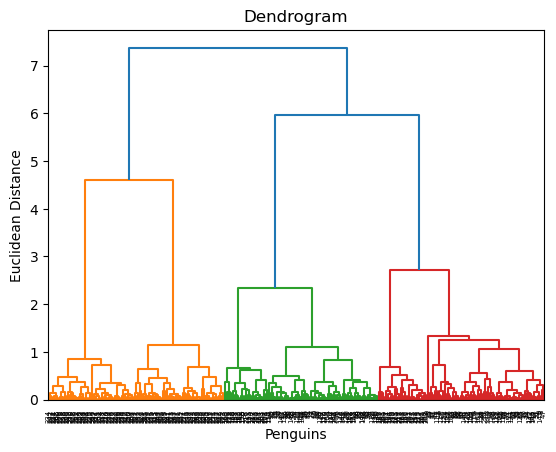

In [22]:
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram' )
plt.xlabel('Penguins')
plt.ylabel('Euclidean Distance')
plt.show()

In [26]:
#Data Clustering and Evaluation
#Membangun model klustering dengan beberapa pilihan nomor kluster
#Menguji dengan metrik Davies Bouldin Score,
#Silhouette Score dan Calinski-Harabasz Index
# gunakan dictionary untuk menyimpan metrik per jumlah kluster
db, slc, chs = {}, {}, {}
for i in range(2, 10):
    hc = AgglomerativeClustering(n_clusters=i, metric='euclidean', memory=None,
    connectivity=None, compute_full_tree='auto',
    linkage='ward', distance_threshold=None, compute_distances=False)
    y_hc = hc.fit_predict(X)

    db[i] = davies_bouldin_score(X, y_hc)
    slc[i] = silhouette_score(X, y_hc)
    chs[i] = calinski_harabasz_score(X, y_hc)
    print("Kluster {}".format(i))
    print("Davies Bouldin Score = {}".format(db[i]))
    print("Silhouette Score = {}".format(slc[i]))
    print("Calinski-Harabasz Index = {}".format(chs[i]))

Kluster 2
Davies Bouldin Score = 1.1770044785955698
Silhouette Score = 0.3886736250999642
Calinski-Harabasz Index = 207.27788413039153
Kluster 3
Davies Bouldin Score = 0.8593949536629655
Silhouette Score = 0.4615865744063622
Calinski-Harabasz Index = 282.4789915176425
Kluster 4
Davies Bouldin Score = 0.6969472572749702
Silhouette Score = 0.5476000877135362
Calinski-Harabasz Index = 381.42978874734723
Kluster 5
Davies Bouldin Score = 0.6697554482465193
Silhouette Score = 0.5462067633532446
Calinski-Harabasz Index = 391.7218918728924
Kluster 6
Davies Bouldin Score = 0.6981974890175217
Silhouette Score = 0.5337340741234605
Calinski-Harabasz Index = 415.04683958484117
Kluster 7
Davies Bouldin Score = 0.6140027458855428
Silhouette Score = 0.5377339256380043
Calinski-Harabasz Index = 383.9852951254286
Kluster 8
Davies Bouldin Score = 0.755955585402823
Silhouette Score = 0.4993896515482328
Calinski-Harabasz Index = 362.86068991217184
Kluster 9
Davies Bouldin Score = 0.8790700015650952
Silhoue

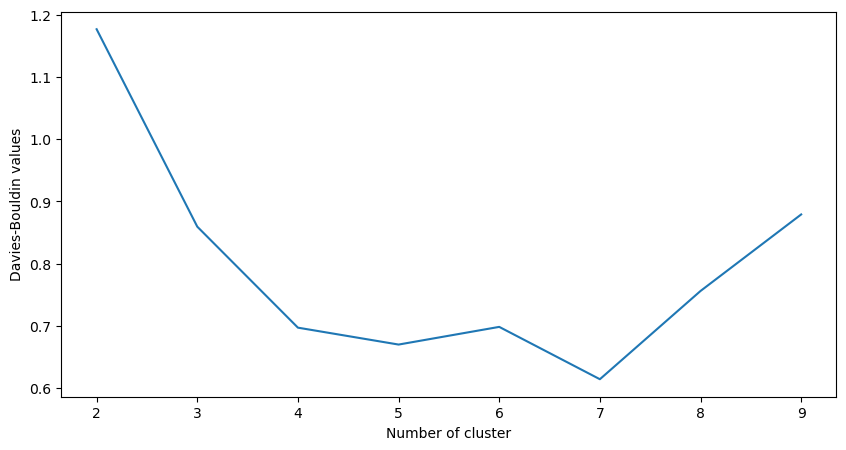

In [27]:
#Menampilkan visualisasi nilai Davies-Bouldin Score
plt.figure(figsize=(10,5))
plt.plot(list(db.keys()), list(db.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Davies-Bouldin values")
plt.show()

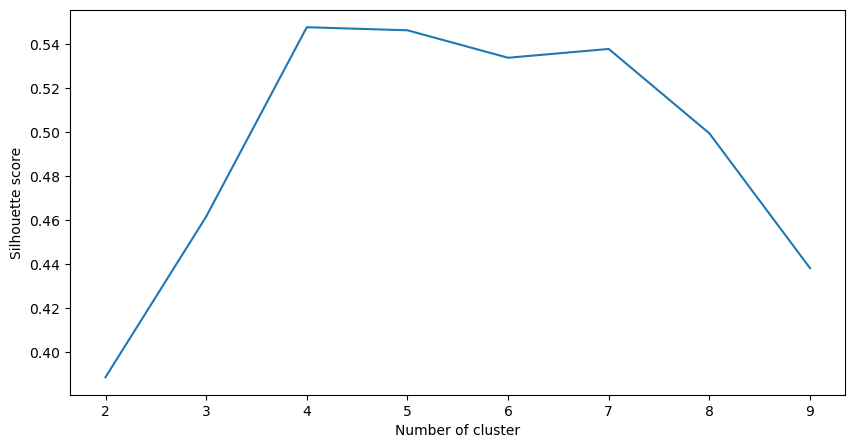

In [28]:
#Menampilkan visualisasi nilai Silhouette score
plt.figure(figsize=(10,5))
plt.plot(list(slc.keys()), list(slc.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette score")
plt.show()

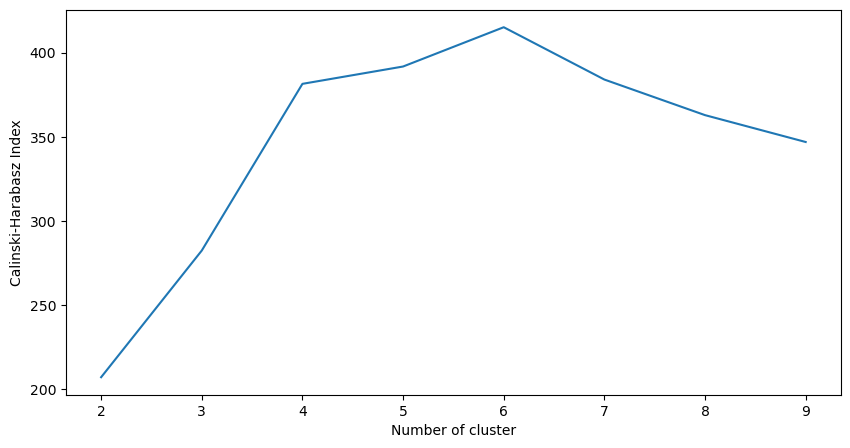

In [29]:
#Menampilkan visualisasi nilai Calinski-Harabasz Index
plt.figure(figsize=(10,5))
plt.plot(list(chs.keys()), list(chs.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Calinski-Harabasz Index")
plt.show()

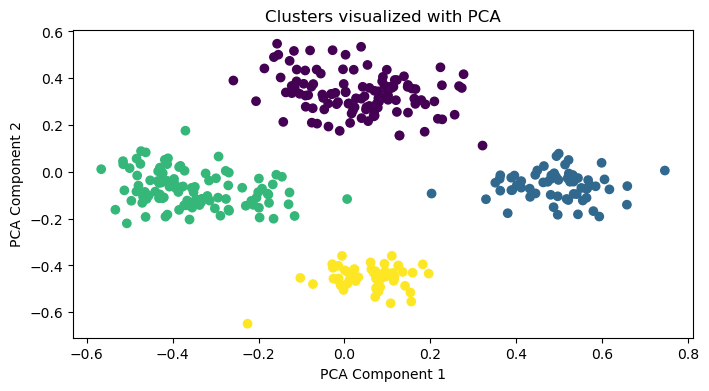

In [30]:
#Menampilkan hasil visualisasi clustering dengan nilai kluster=4
#menggunakan metode PCA untuk reduksi dimensi menjadi 2 dimensi
hc = AgglomerativeClustering(n_clusters=4, metric='euclidean', memory=None,
connectivity=None, compute_full_tree='auto',
linkage='ward', distance_threshold=None, compute_distances=False)

y_hc = hc.fit_predict(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_hc, cmap='viridis')
plt.title("Clusters visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

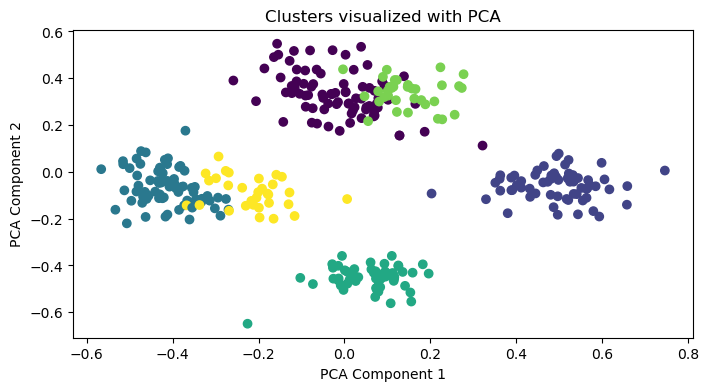

In [31]:
#Menampilkan hasil visualisasi clustering dengan nilai kluster=6
#menggunakan metode PCA untuk reduksi dimensi menjadi 2 dimensi
hc = AgglomerativeClustering(n_clusters=6, metric='euclidean', memory=None,
connectivity=None, compute_full_tree='auto',
linkage='ward', distance_threshold=None, compute_distances=False)

y_hc = hc.fit_predict(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_hc, cmap='viridis')
plt.title("Clusters visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

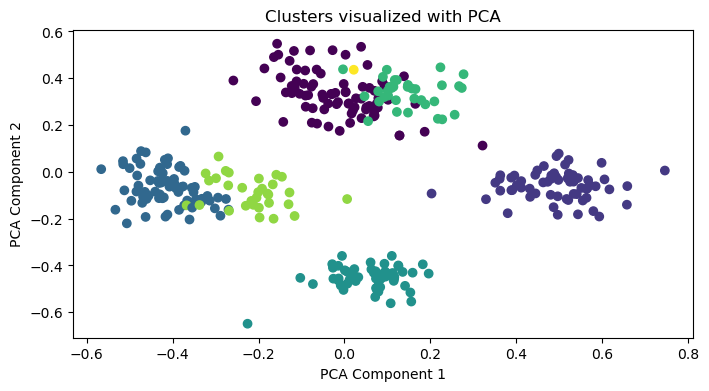

In [32]:
#Menampilkan hasil visualisasi clustering dengan nilai kluster=7
#menggunakan metode PCA untuk reduksi dimensi menjadi 2 dimensi
hc = AgglomerativeClustering(n_clusters=7, metric='euclidean', memory=None,
connectivity=None, compute_full_tree='auto',
linkage='ward', distance_threshold=None, compute_distances=False)

y_hc = hc.fit_predict(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_hc, cmap='viridis' )
plt.title("Clusters visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()